# Dynamical Decoupling and Randomized Benchmarking on 2 qubit

## Setup

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from qutip import *

import qutip_qip
from qutip_qip.circuit import QubitCircuit
from qutip.qip.operations import *
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import Model, ModelProcessor, Processor
from qutip_qip.noise import Noise
from qutip.qip.noise import RandomNoise # for Gaussian noise
from qutip.qip.pulse import Pulse
from qutip.qip.gates import *

from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

import functools # for reduce
from joblib import Parallel, delayed  # for parallel simulations
import itertools # for RB inverse search

C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_15276\3713021909.py:16: DeprecationWarning: Importation from qutip.qip.gates is deprecated.Please use e.g.
 from qutip.qip.operations import cnot

  from qutip.qip.gates import *


In [2]:
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
with open("rename.py") as f:
    exec(f.read())

## Finding pulse duration

Parameters

In [4]:
VStd = 0.1
phaseStd = 0.382 / 180 * np.pi

detuningStd = 52769
samplingRate = 5898.24e6 # 5.89824 GS/s
omega = 20e6 # 20MHz

VNaught = 1
hbar = 1
phiNaught = 0
aNaught = 25 / 46

V = VNaught + np.random.normal(scale=VStd)
phi = phiNaught + np.random.normal(scale=phaseStd)
I = np.cos(phi)
Q = np.sin(phi)

# Decoherence time
T1 = 8.66e-6
T1_err = 0.49
T2 = 9.08e-6
T2_err = 0.74e-6
T2_echo = 16.14e-6
T2_echo_err = 3.21e-6

# Initial condition
psi0 = basis(2,0)
t_0 = 0

Finding the pulse duration. When specifying Python functions for coefficients, the function must have (t,args) as the input variables, in that order.

In [5]:
# This code takes 2 minutes to run, maybe sesolve is not optimized for this
t_final = 100e-9
n_steps = int(samplingRate * (t_final - t_0))
t_find_pulse = np.linspace(t_0, t_final, n_steps)
def H_find_pulse(t, args):
    dwt = np.random.normal(scale=detuningStd) * t
    s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / t_final)
    # For 2 qubit
    # return omega * np.pi * V * s *((-I * np.cos(dwt) + Q * np.sin(dwt)) * tensor(identity(2),sigma_x()) + (I * np.sin(dwt) - Q * np.cos(dwt)) * tensor(identity(2),sigma_y()))
    return omega * np.pi * V * s *((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigma_x() + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigma_y())
# For 2 qubit
# result_find_pulse = sesolve(H_find_pulse, psi0, t_find_pulse, [tensor(sigmaz(),sigmaz())],options=Options(nsteps=10000))
result_find_pulse = sesolve(H_find_pulse, psi0, t_find_pulse, [sigmaz()],options=Options(nsteps=10000))

(<Figure size 800x400 with 1 Axes>,
 array([[<Axes: xlabel='time'>]], dtype=object))

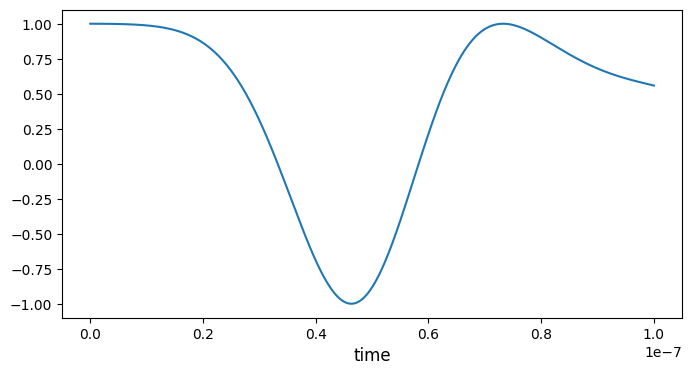

In [6]:
plot_expectation_values(result_find_pulse)

Find the pi-pulse by optimizing

In [7]:
minimum_array = argrelextrema(result_find_pulse.expect[0], np.less)
first_min = minimum_array[0][0]
pi_pulse_duration = result_find_pulse.times[first_min]
pi_half_pulse_duration = pi_pulse_duration/2
print(pi_pulse_duration,pi_half_pulse_duration)

4.625850340136054e-08 2.312925170068027e-08


Solving the Hamiltonian

In [8]:
def H(t, args):
    dwt = np.random.normal(scale=detuningStd) * t
    s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * t / pi_pulse_duration)
    # return omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * tensor(identity(2),sigma_x()) + (I * np.sin(dwt) - Q * np.cos(dwt)) * tensor(identity(2),sigma_y()))
    return omega * np.pi * V * s * ((-I * np.cos(dwt) + Q * np.sin(dwt)) * sigma_x() + (I * np.sin(dwt) - Q * np.cos(dwt)) * sigma_y())

In [9]:
n_steps = int(samplingRate * (pi_pulse_duration - t_0))
t = np.linspace(t_0, pi_pulse_duration, n_steps)
# result = sesolve(H, psi0, t, [tensor(identity(2),sigmaz()),tensor(identity(2),sigmax()),tensor(identity(2),sigmay())],options=Options(nsteps=10000))
result = sesolve(H, psi0, t, [sigmaz(),sigmax(),sigmay()],options=Options(nsteps=10000))

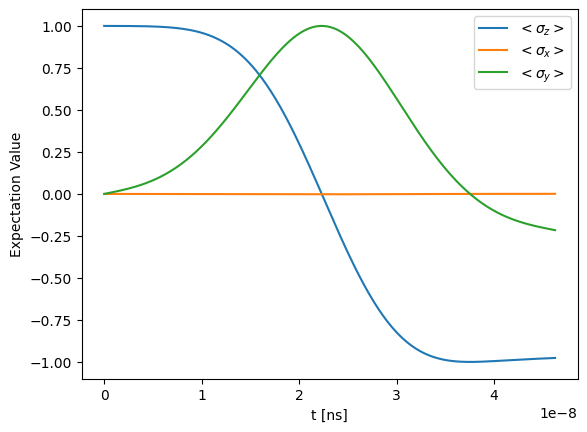

In [10]:
plt.plot(t, np.transpose(result.expect), label=[r"$<\sigma_z>$", r"$<\sigma_x>$", r"$<\sigma_y>$"])
plt.xlabel("t [ns]")
plt.ylabel("Expectation Value")
plt.legend()

In [13]:
np.savetxt('pulse_duration.txt',[pi_pulse_duration,pi_half_pulse_duration])